# Teacher model training, retrieval & evaluation

This notebook trains the multimodal `TeacherModel` (text + image), implements a retrieval function that uses the teacher model (feeding both definition and corresponding image), and computes recall@1/5/10/20, test MSE, and average cosine similarity.

Notes:
- Make sure required packages are installed: `numpy`, `torch`, `transformers`, `torchvision`, `tqdm`, `scikit-learn`, `matplotlib` (if you want to visualize).
- Training ResNet + BERT on CPU can be slow. Consider running on GPU if available.


In [1]:
# Environment check and imports
try:
    import torch, numpy as np
    import transformers
    import torchvision
    print('Found: torch, numpy, transformers, torchvision')
except Exception as e:
    print('Missing packages. Install with:')
    print('  python3 -m pip install numpy torch transformers torchvision tqdm scikit-learn')
    raise

# Imports from project
from teacher import (
    TeacherModel,
    TeacherDataset,
    load_glove_embeddings,
    train_one_epoch,
    evaluate,
    collate_examples,
)

from pathlib import Path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

print('Imports OK')


/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found: torch, numpy, transformers, torchvision
Imports OK
Imports OK


In [2]:
# Config
DATASET = 'dataset.json'
GLOVE = './glove.6B.300d.txt'
BERT = 'bert-base-uncased'
BATCH = 8
EPOCHS = 15
LR = 2e-5
MAXLEN = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print('Device:', DEVICE)


Device: mps


In [3]:
# Load GloVe and dataset
print('Loading GloVe...')
glove = load_glove_embeddings(GLOVE)
print('GloVe dim =', next(iter(glove.values())).shape[0])

print('Loading dataset...')
ds = TeacherDataset(DATASET, glove, tokenizer_name=BERT, max_length=MAXLEN)

n = len(ds)
print('Dataset size:', n)

# random 90/10 split
import random
indices = list(range(n))
random.shuffle(indices)
train_n = int(0.9 * n)
train_idx = indices[:train_n]
test_idx = indices[train_n:]

train_ds = torch.utils.data.Subset(ds, train_idx)
test_ds = torch.utils.data.Subset(ds, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, collate_fn=lambda x: collate_examples(x))
val_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, collate_fn=lambda x: collate_examples(x))

print('Train size:', len(train_ds), 'Test size:', len(test_ds))


Loading GloVe...
GloVe dim = 300
Loading dataset...
GloVe dim = 300
Loading dataset...
Dataset size: 971
Train size: 873 Test size: 98
Dataset size: 971
Train size: 873 Test size: 98


In [4]:
# Build model, optimizer, criterion
model = TeacherModel(bert_model_name=BERT, target_dim=next(iter(glove.values())).shape[0], modality_dropout_p=0.0)
model.to(DEVICE)
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR)
criterion = torch.nn.MSELoss()

print('Model created; training will run for', EPOCHS, 'epochs')


/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created; training will run for 15 epochs


In [5]:
losses = []

# Training loop (20 epochs)
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE, criterion)
    val_loss = evaluate(model, val_loader, DEVICE, criterion)
    print(f"Epoch {epoch}: train_loss={train_loss:.6f} val_loss={val_loss:.6f}")

    losses.append(val_loss)
    if losses[-1] == min(losses):
        # Save model
        model_path = Path('./ckpts/teacher_model.pt')
        model_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), model_path)
        print('Saved best model to', model_path)


Epoch 1: train_loss=0.150336 val_loss=0.147798
Saved best model to ckpts/teacher_model.pt
Saved best model to ckpts/teacher_model.pt
Epoch 2: train_loss=0.122549 val_loss=0.126228
Epoch 2: train_loss=0.122549 val_loss=0.126228
Saved best model to ckpts/teacher_model.pt
Saved best model to ckpts/teacher_model.pt
Epoch 3: train_loss=0.114385 val_loss=0.122111
Epoch 3: train_loss=0.114385 val_loss=0.122111
Saved best model to ckpts/teacher_model.pt
Saved best model to ckpts/teacher_model.pt
Epoch 4: train_loss=0.107536 val_loss=0.120320
Epoch 4: train_loss=0.107536 val_loss=0.120320
Saved best model to ckpts/teacher_model.pt
Saved best model to ckpts/teacher_model.pt
Epoch 5: train_loss=0.101537 val_loss=0.120800
Epoch 5: train_loss=0.101537 val_loss=0.120800
Epoch 6: train_loss=0.094991 val_loss=0.121811
Epoch 6: train_loss=0.094991 val_loss=0.121811
Epoch 7: train_loss=0.088839 val_loss=0.122615
Epoch 7: train_loss=0.088839 val_loss=0.122615
Epoch 8: train_loss=0.083315 val_loss=0.12349

Text(0.5, 1.0, 'Loss over Epochs')

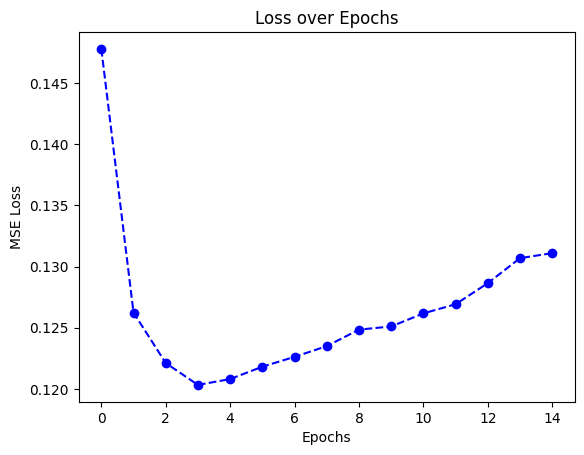

In [8]:
import matplotlib.pyplot as plt

x = range(15)

plt.plot(x, losses, color='blue', marker='o', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss over Epochs")

In [6]:
# Prepare DB vectors (GloVe) for retrieval (full dataset)
db_words = [ex['word'] for ex in ds.examples]
db_defs = [ex['definition'] for ex in ds.examples]
db_vectors = np.stack([ex['vector'] for ex in ds.examples])
# normalize
db_norms = np.linalg.norm(db_vectors, axis=1)
db_norms[db_norms == 0] = 1.0

# retrieval: definition -> use corresponding image and teacher model to get query vector

def retrieve_topk(definition: str, k: int = 10, model=model, ds=ds, device=DEVICE):
    # find an example matching the definition (first match)
    idx = None
    for i, ex in enumerate(ds.examples):
        if ex['definition'] == definition:
            idx = i
            break
    if idx is None:
        # fallback: use tokenizer only (no image)
        toks = ds.tokenizer(definition, truncation=True, padding='max_length', max_length=ds.max_length, return_tensors='pt')
        input_ids = toks['input_ids'].to(device)
        attention_mask = toks['attention_mask'].to(device)
        image = torch.zeros(1,3,224,224).to(device)
    else:
        # use ds[idx] to get tokens and image
        sample = ds[idx]
        input_ids = sample['input_ids'].unsqueeze(0).to(device)
        attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
        image = sample['image'].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        q = model(input_ids=input_ids, attention_mask=attention_mask, image=image, training=False)
    q = q.cpu().numpy().reshape(-1)
    q_norm = np.linalg.norm(q)
    if q_norm == 0:
        q_norm = 1.0
    sims = (db_vectors @ q) / (db_norms * q_norm)
    idxs = np.argsort(-sims)[:k]
    return [(db_words[i], db_defs[i], float(sims[i])) for i in idxs]

print('Retrieval helper ready')


Retrieval helper ready


In [9]:
# Evaluate recall@1,5,10,20 and test MSE / average cosine similarity
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

k_values = [1,5,10,20]
correct = defaultdict(int)
num_test = len(test_idx)
ranks = []

total_mse = 0.0
total_cos = 0.0

for idx in tqdm(test_idx, desc='Evaluating test set'):
    # get sample from dataset
    sample = ds[idx]
    input_ids = sample['input_ids'].unsqueeze(0).to(DEVICE)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(DEVICE)
    image = sample['image'].unsqueeze(0).to(DEVICE)
    gt_vec = sample['vector'].numpy()
    gt_word = sample['word']

    model.eval()
    with torch.no_grad():
        pred = model(input_ids=input_ids, attention_mask=attention_mask, image=image, training=False)
    pred_np = pred.cpu().numpy().reshape(-1)

    # MSE for this sample
    mse = np.mean((pred_np - gt_vec) ** 2)
    total_mse += mse

    # cosine similarity with ground truth
    cos = np.dot(pred_np, gt_vec) / (np.linalg.norm(pred_np) * (np.linalg.norm(gt_vec) if np.linalg.norm(gt_vec)>0 else 1.0))
    total_cos += cos

    # retrieval
    sims = (db_vectors @ pred_np) / (db_norms * (np.linalg.norm(pred_np) if np.linalg.norm(pred_np)>0 else 1.0))
    idxs = np.argsort(-sims)[:len(ds)]
    retrieved = [db_words[i] for i in idxs]

    for k in k_values:
        if sample['word'] in retrieved[:k]:
            correct[k] += 1

    # Find rank of ground truth word (1-indexed)
    if gt_word in retrieved:
        rank = retrieved.index(gt_word) + 1
        ranks.append(rank)
    else:
        # If not found, append length of database
        ranks.append(len(db_words))

# Final metrics
avg_mse = total_mse / num_test
avg_cos = total_cos / num_test

print(f'Num test examples: {num_test}')
for k in k_values:
    print(f'Recall@{k}: {correct[k]}/{num_test} = {correct[k]/num_test:.4f}')
print(f'Test MSE (avg): {avg_mse:.6f}')
print(f'Average cosine similarity (pred vs GT): {avg_cos:.6f}')
median_rank = np.median(ranks)
average_rank = np.mean(ranks)
print(f'Median Rank: {median_rank:.1f}')
print(f'Average Rank: {average_rank:.2f}')


Evaluating test set: 100%|██████████| 98/98 [00:02<00:00, 35.05it/s]

Num test examples: 98
Recall@1: 4/98 = 0.0408
Recall@5: 18/98 = 0.1837
Recall@10: 34/98 = 0.3469
Recall@20: 43/98 = 0.4388
Test MSE (avg): 0.131097
Average cosine similarity (pred vs GT): 0.349440
Median Rank: 29.5
Average Rank: 83.81


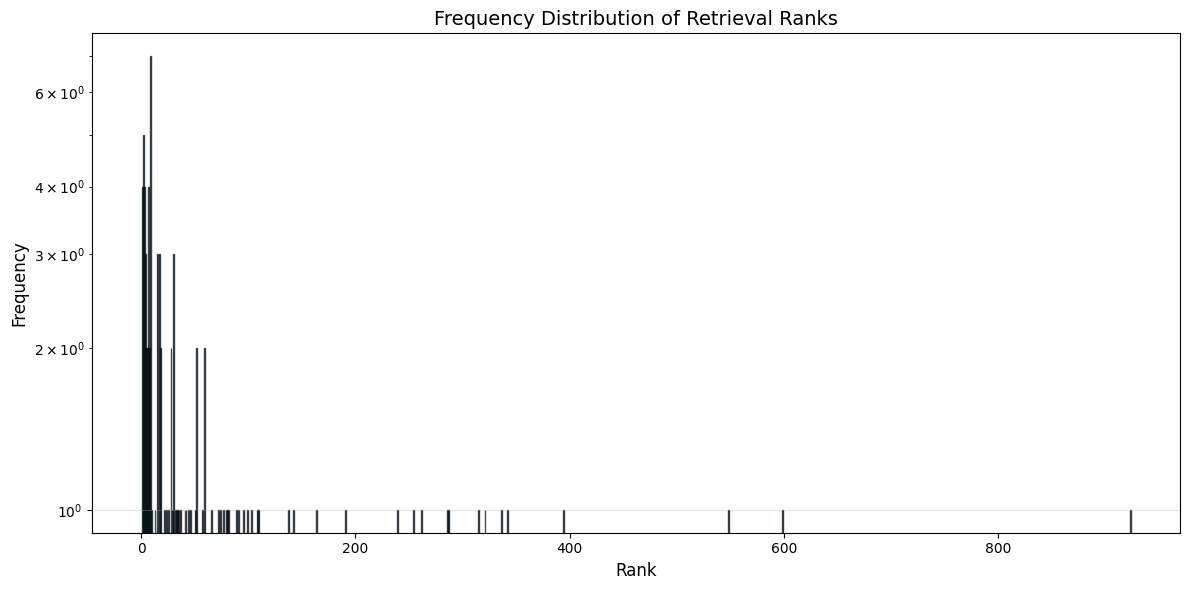

Rank range: 1 to 923
Most common ranks: [(9, 7), (2, 5), (3, 4), (7, 4), (1, 4), (17, 3), (15, 3), (30, 3), (4, 3), (28, 2)]


In [10]:
from collections import Counter

import matplotlib.pyplot as plt

# Count frequency of each rank
rank_counts = Counter(ranks)

# Sort by rank
sorted_ranks = sorted(rank_counts.keys())
frequencies = [rank_counts[r] for r in sorted_ranks]

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_ranks, frequencies, edgecolor='black', alpha=0.7)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Retrieval Ranks', fontsize=14)
plt.yscale('log')  # log scale to see smaller frequencies
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Rank range: {min(sorted_ranks)} to {max(sorted_ranks)}")
print(f"Most common ranks: {rank_counts.most_common(10)}")